# Binary Classification - CNN

This introduction exercise demonstrates binary classification with the following key steps:

- **Dataset** (Exploring)
- **Data Loader** (Exploring batches principle)
- **Model Class**
    - Build layer without `nn.Sequence`
    - SGD for optimizer
    - `nn.BCELoss()` for loss function
- **Training Loop** (Training the Model)
- **Model Summary** (Model summary layer by layer)
- **Model Evaluation** (Accuracy, precission, recall & F1)
- **Save and Load Model**
- **Making Predictions**


*Note: Jupyter Notebook under Windows*

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
os.getcwd()

'D:\\Course\\ML_Notes_exercise\\4_Computer_Vision'

## Dataset

### Visualizing random image

In [2]:
import random
from PIL import Image

In [3]:
# Set the base directory
base_dir = 'data/train/'

# Walk through the directory and subdirectories to get all image paths
image_paths = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        # Check if the file is an image
        if file.lower().endswith(('jpg')):
            image_paths.append(os.path.join(root, file))


Random image selected: 00467.jpg
Class name: No-crack
image size: (227, 227)



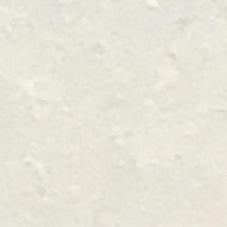

In [4]:
# Select a random image path
random_image = random.choice(image_paths)
print(f"Random image selected: {os.path.basename(random_image)}")
print(f"Class name: {os.path.basename(os.path.dirname(random_image))}")

im = Image.open(random_image)
print(f"image size: {im.size}\n")
im

### Augmented image

In [5]:
augmented_data = transforms.Compose(
    [transforms.Resize(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))])

In [6]:
# Batch size
BATCH_SIZE = 4

train_data = ImageFolder(root='data/train', transform=augmented_data)
test_data = ImageFolder(root='data/test', transform=augmented_data)

trainloader = DataLoader(
    train_data, # Pick train data
    batch_size = BATCH_SIZE,
    shuffle =True
)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
# classes = ['Crack', 'No-crack']

In [7]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 1000
     Root location: data/train
     StandardTransform
 Transform: Compose(
                Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
                Grayscale(num_output_channels=1)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset ImageFolder
     Number of datapoints: 600
     Root location: data/test
     StandardTransform
 Transform: Compose(
                Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
                Grayscale(num_output_channels=1)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

### Visualizing Batch images

In [8]:
class_names = train_data.classes
class_names

['Crack', 'No-crack']

In [9]:
def implot(img):
    img = img / 2 + 0.5 # Bring back img from range [0, 1] to [0, 255]
    print(img.shape)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # rearrange axex from (C, H, W) to (H, W, C)
    plt.show()

Label: tensor([1, 1, 1, 1])
Label name: ['No-crack', 'No-crack', 'No-crack', 'No-crack']
torch.Size([3, 70, 70])


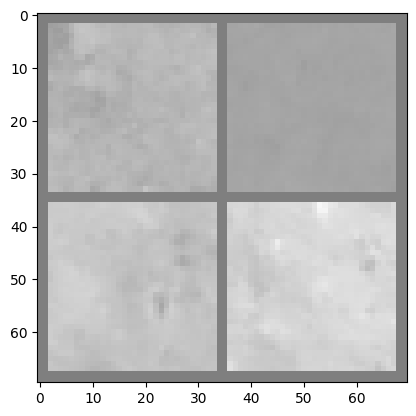

In [10]:
# Visualizing batch size images
dataiter = iter(trainloader) # Converting trainloader to iterator
images, labels = next(dataiter) # This will give you the next batch of images and labels from the trainloader
print(f"Label: {labels}")

# Convert labels to class names
label_name = [class_names[label] for label in labels]
print(f"Label name: {label_name}")

implot(torchvision.utils.make_grid(images, nrow=2))

In [11]:
augmented_data(im)


tensor([[[0.7882, 0.7882, 0.7804,  ..., 0.7804, 0.7725, 0.7804],
         [0.8196, 0.8118, 0.7961,  ..., 0.7882, 0.7882, 0.7569],
         [0.8039, 0.8039, 0.8039,  ..., 0.8039, 0.7882, 0.7804],
         ...,
         [0.7725, 0.7647, 0.7804,  ..., 0.7725, 0.7804, 0.7804],
         [0.7725, 0.7725, 0.7725,  ..., 0.7882, 0.7882, 0.7804],
         [0.7804, 0.7961, 0.7882,  ..., 0.7882, 0.7882, 0.7882]]])

Text(0.5, 0.98, 'Class name: No-crack')

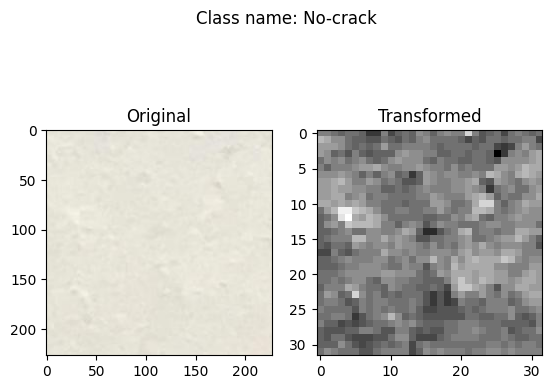

In [12]:
# Plot Original vs transformed
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im)
ax[0].set_title('Original')

t = augmented_data(im).permute(1, 2, 0).numpy()
ax[1].imshow(t.squeeze(), cmap='gray')
ax[1].set_title('Transformed')

fig.suptitle(f"Class name: {os.path.basename(os.path.dirname(random_image))}")

## Model Architecture

Convolutional and pooling > flatten > fully connected layer
![Image Description](https://miro.medium.com/v2/resize:fit:720/format:webp/1*U9nOagJUzwFUFQW30b-92Q.png)



### Model class

In [13]:
class BinaryCNN(nn.Module):
    # We define layer in init and some will be used more than 1 times
    def __init__(self):
        super().__init__()
        # 1st convolutional layer: in_channels=1, out_chanels=6, kernel_size=(3, 3)
        self.conv_1 = nn.Conv2d(1, 6, 3) 
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2) # kernel_size=2, stride=2, it same as nn.Maxpool2D(2)
        
        # 2nd convolutional layer: in_channels=6, out_chanels=10, kernel_size=(3, 3)
        self.conv_2 = nn.Conv2d(6, 16, 3)

        # Fully connected layers
        self.fc_1 = nn.Linear(in_features = 16 * 6 * 6, out_features=128)
        self.fc_2 = nn.Linear(in_features=128, out_features=64)
        self.fc_3 = nn.Linear(in_features=64, out_features=10)
        self.fc_4 = nn.Linear(in_features=10, out_features=1)

        # Use sigmoid for finals binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply first convolution, activation, and pooling
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Apply second convolution, activation, and pooling
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten the feature maps for fully connected layers
        x = torch.flatten(x, 1)
        
        # Pass through fully connected layers
        x = self.fc_1(x)
        x = self.relu(x)
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.fc_3(x)
        x = self.relu(x)
        x = self.fc_4(x)
        
        # Apply sigmoid activation for binary classification output
        x = self.sigmoid(x)

        return x
        

### Model Initialization

In [14]:
torch.manual_seed(42)
model = BinaryCNN()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
model

BinaryCNN(
  (conv_1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=64, bias=True)
  (fc_3): Linear(in_features=64, out_features=10, bias=True)
  (fc_4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Training Loop

In [15]:
num_epochs = 3

for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    
    for batch, data in enumerate(trainloader, 0):
        inputs, labels = data
        model.train()

        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        train_loss = loss_fn(outputs, labels.view(-1, 1).float())
        train_losses.append(train_loss.item())
        
        # optimizer zero grad
        optimizer.zero_grad()
        
        # loss backward
        train_loss.backward()
        
        # Optimizer step
        optimizer.step()

        if batch % 100 == 0:
            print(f"Looked at batch {batch * len(inputs)}/{len(train_data)} samples")

        # TESTING
        model.eval()
        with torch.no_grad():  # Use no_grad() to save memory during inference
            test_pred = model(inputs)
            test_loss = loss_fn(test_pred, labels.view(-1, 1).float())
            test_losses.append(test_loss.item())
    
    # Calculate average losses for the epoch
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_test_loss = sum(test_losses) / len(test_losses)

    print(f"\nTrain loss: {avg_train_loss:.5f} | Test loss: {avg_test_loss:.5f}\n")

        

Looked at batch 0/1000 samples
Looked at batch 400/1000 samples
Looked at batch 800/1000 samples

Train loss: 0.54007 | Test loss: 0.44187

Looked at batch 0/1000 samples
Looked at batch 400/1000 samples
Looked at batch 800/1000 samples

Train loss: 0.27094 | Test loss: 0.18055

Looked at batch 0/1000 samples
Looked at batch 400/1000 samples
Looked at batch 800/1000 samples

Train loss: 0.15562 | Test loss: 0.08670



### Model Summary

In [16]:
from torchinfo import summary
batch_size = 4
summary(model, input_size=(batch_size, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
BinaryCNN                                [4, 1]                    --
├─Conv2d: 1-1                            [4, 6, 30, 30]            60
├─ReLU: 1-2                              [4, 6, 30, 30]            --
├─MaxPool2d: 1-3                         [4, 6, 15, 15]            --
├─Conv2d: 1-4                            [4, 16, 13, 13]           880
├─ReLU: 1-5                              [4, 16, 13, 13]           --
├─MaxPool2d: 1-6                         [4, 16, 6, 6]             --
├─Linear: 1-7                            [4, 128]                  73,856
├─ReLU: 1-8                              [4, 128]                  --
├─Linear: 1-9                            [4, 64]                   8,256
├─ReLU: 1-10                             [4, 64]                   --
├─Linear: 1-11                           [4, 10]                   650
├─ReLU: 1-12                             [4, 10]                   --
├─Line

## Evaluation

In [17]:
y_test = []
y_test_hat = []
for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    with torch.no_grad():
        y_test_hat_temp = model(inputs).round()
    
    y_test.extend(y_test_temp.numpy())
    y_test_hat.extend(y_test_hat_temp.numpy())

acc = accuracy_score(y_test, y_test_hat)
print(f'Accuracy: {acc*100:.2f} %')

Accuracy: 93.33 %


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_test_hat)
recall = recall_score(y_test, y_test_hat)
f1 = f1_score(y_test, y_test_hat)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Precision: 0.91
Recall: 0.97
F1 Score: 0.94


## Save & Load Model

### Save Model

In [21]:
from pathlib import Path

# Create models directory (if it doesn't already exist)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "crack_cnn.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save model state dict
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)
print(f"Saving model to: {MODEL_SAVE_PATH}")

Saving model to: models\crack_cnn.pth


### Load Model

In [22]:
loaded_model = BinaryCNN()

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))

# Send model to GPU
# loaded_model = loaded_model.to(device)
loaded_model

BinaryCNN(
  (conv_1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=64, bias=True)
  (fc_3): Linear(in_features=64, out_features=10, bias=True)
  (fc_4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Making Predictions

In [27]:
test_dir = 'data/test/'
test_path = []
NUM_TESTS = 9

for root, dirs, files in os.walk(test_dir):
    for file in files:
        # Check if the file is an image
        if file.lower().endswith(('jpg')):
            test_path.append(os.path.join(root, file))

random_items = random.sample(test_path, 9)

In [28]:
random_items

['data/test/Crack\\00617.jpg',
 'data/test/Crack\\00688.jpg',
 'data/test/No-crack\\00532.jpg',
 'data/test/No-crack\\00574.jpg',
 'data/test/No-crack\\00538.jpg',
 'data/test/Crack\\00565.jpg',
 'data/test/No-crack\\00600.jpg',
 'data/test/Crack\\00630.jpg',
 'data/test/Crack\\00749.jpg']

In [29]:
# List to store predictions by loaded model
loaded_predictions = []

loaded_model.eval()
for i in random_items:
    image = Image.open(i)

    # Apply transformations
    image_tensor = augmented_data(image)
    
    # If you need a batch dimension (for model inference), add it:
    image_tensor = image_tensor.unsqueeze(0)  # Shape: (1, 1, 32, 32)

    with torch.no_grad():
        y_test_loaded = int(loaded_model(image_tensor).round().item())
    loaded_predictions.append(y_test_loaded)
loaded_predictions

[0, 0, 1, 1, 1, 0, 1, 0, 1]

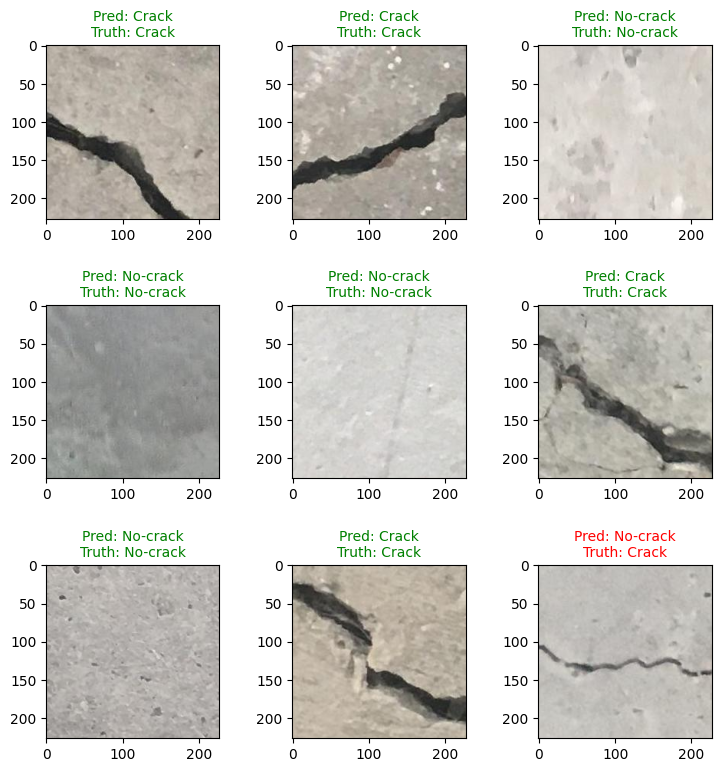

In [30]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(random_items):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(Image.open(sample))

    truth_label = os.path.basename(os.path.dirname(sample))
    predicted_label = class_names[loaded_predictions[i]]
    
    if predicted_label == truth_label:
      plt.title(f"Pred: {predicted_label}\nTruth: {truth_label}", fontsize=10, c="g") # green text if correct
    else:
      plt.title(f"Pred: {predicted_label}\nTruth: {truth_label}", fontsize=10, c="r") # red text if wrong

# Adjust vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)  # Adjust this value to increase/decrease the gap

plt.show()